In [31]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

## 1. 이미지 불러오기

(640, 640, 3)


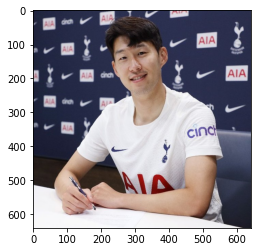

In [32]:

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/son.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show() 

## 2. DeepLab 모델 준비

In [33]:
# 저장할 파일 이름을 결정
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fd629390d60>)

## 3. 이미지 세그멘테이션

In [34]:
#pixelLib로 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [35]:
#여기에 이미지를 입력해보자.
segvalues, output = model.segmentAsPascalvoc(img_path)

In [36]:
#Pascalvoc의 lable name은 다음과 같다.
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

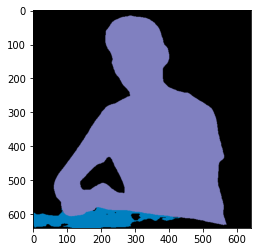

In [37]:
#모델에서 나온 출력값
plt.imshow(output)
plt.show()

In [38]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
diningtable
person


In [39]:
#물체마다 output에 어떤 색상으로 나타나는지 알아보자
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [40]:
colormap[15] #사람을 나타내는 colormap

array([192, 128, 128])

In [41]:
seg_color = (128,128,192) #output이 BRG로 되어있기 때문에 변경해주자

(640, 640)


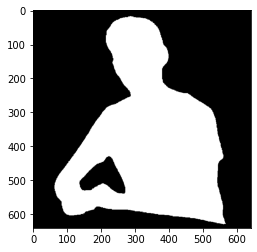

In [42]:
# 물체가 있으면 1, 없으면 0 으로
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

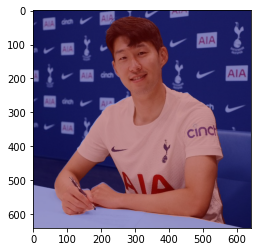

In [43]:
#원본 이미지랑 겹쳐보기 
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 변경 
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합치기
# 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 4. 이미지 blur 처리 

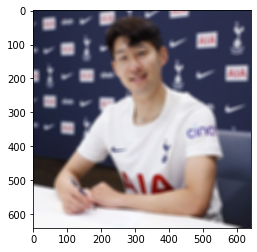

In [54]:
# (13,13)은 blurring kernel size
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

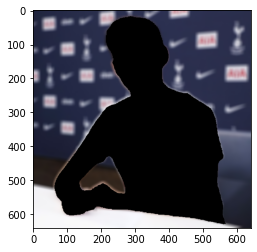

In [47]:
#세그멘테이션 이미지를 이용해 배경만 추출해보자
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #배경 0 사람 255 > 배경 255 사람 0 
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경은 blur, 사람은 0 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


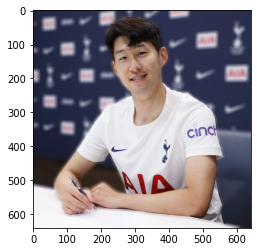

In [51]:
#위에서 얻은 흐린 배경과 사람 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)#255인곳은 원본 이미지 , 나머지는 blur배경 가져오기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 문제점 파악
원본사진이 합성되기 전의 경계를 파악해보면, 경계가 정확히 나누어져 아웃포커싱도 자연스럽게 될 것이라고 예상했지만, 인물이 사진이 어딘가 모르게 흐릿하고, 블러처리된 곳과 안된곳의 차이가 명확하지 않다는 문제점을 파악했다. 이 문제점을 해결해보자.

**해결방안**
 - 경계를 더욱 명확하게 하기 위해, 배경의 블러를 더 흐릿하게 하여 인물과 더 뚜렷하게 대비되도록 설정해보자

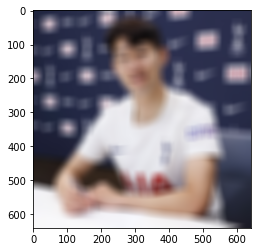

In [58]:
# blurring kernel size를 (13,13)>(30,30)으로 변경
img_orig_blur = cv2.blur(img_orig, (30,30))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

전보다 확실히 더 흐릿해졌다.

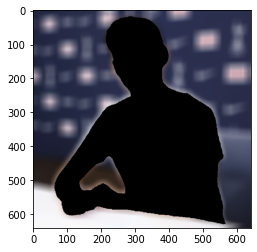

In [59]:
# 배경 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #배경 0 사람 255 > 배경 255 사람 0 
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경은 blur, 사람은 0 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


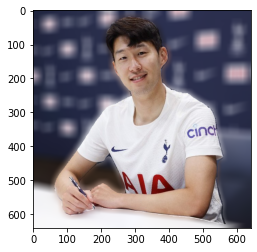

In [60]:
# 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)#255인곳은 원본 이미지 , 나머지는 blur배경 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

(172, 293, 3)


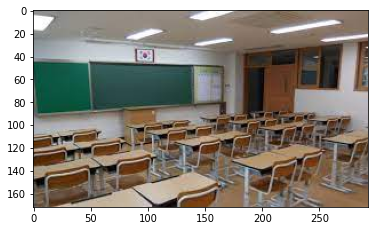

In [63]:
# 이미지 배경을 바꿔보자
img_path = os.getenv('HOME')+ '/aiffel/human_segmentation/images/class.jpeg' 
img_class = cv2.imread(img_path) 
print(img_class.shape)
plt.imshow(cv2.cvtColor(img_class, cv2.COLOR_BGR2RGB))
plt.show() 

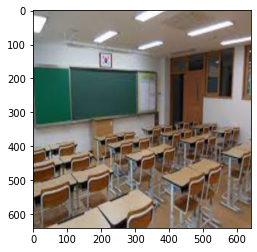

In [66]:
#사진 크기 맞춰주기
target_size = (640,640)
new_class = cv2.resize(img_class, target_size)
plt.imshow(cv2.cvtColor(new_class, cv2.COLOR_BGR2RGB))
plt.show() 

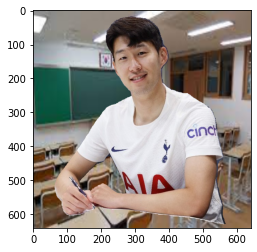

In [67]:
# 합성
img_concat = np.where(img_mask_color==255, img_orig, new_class)#255인곳은 원본 이미지 , 나머지는 교실배경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 6. 회고

**어려웠던 점**

일단 이미지를 세그멘테이션한다는 원리가 이해가 잘 되질 않았다. 모델을 사용하면 한번에 이미지가 바뀌니까 이미지가 어떻게 바뀌는지 알기가 매우 어려웠던것 같다. 또한 처음에 이미지에서 사람 부분을 세그멘테이션 하고, 그 부분만 알아서 색을 바꾸든지 처리를 하든지 하는줄 알았는데, 그게 아니라 세그멘테이션된 부분+ 내가 원하는 배경 이미지로 합성한다는 사실을 알기까지가 조금 오래걸렸다. 주어진 코드를 라인바이라인으로 따라가면서 쳐보니 그제야 조금 이해가 되었다.

**알게된 점**

이번 노드를 통해 앞서 어려웠다고 언급했던 이미지 세그멘테이션에 대해 기초적인 내용을 알게 되었고, 이미지를 합성하고 다루는 방법에 대해 조금 더 자세히 알게 되었다.

**후기**

확실히 이미지 데이터는 결과가 바로바로 보이니까 텍스트 데이터보다는 훨씬 재밌다는 생각이 들었다. 하지만 넘파이 연산이나 이미지를 다루는 기초가 부족해서 노드를 진행하면서 이해가 되지 않는 부분도 조금 있었던 것 같다. 이번 노드를 수행했다고 접어두지 말고, 이미지를 다루는 방법이나 세그멘테이션 모델에 대해 더 공부하고 복습해 둬야겠다.